# Baseline FDMT

IN this book we'll work out how to the baseline FDMT - basically we'll setup a UV grid and work out in which uv cell all the channels live.  All channels that live inside a UV cell will be be given an FDMT with appropriate start and stop frequency. And BAM my friends - that's the baseline FDMT.


In [1]:
from pylab import *
import matplotlib as mpl
import seaborn as sns
import calc11
import numpy as np
from scipy import constants
import fdmt # you'll need to have ../python in  you PYTHONPATH

%matplotlib inline


In [2]:
fc = 1.32 # center frequency GHz
bw = 0.288 # bandwidth GHz
Nd = 1024 # number of DM trials
Nt = 256 # time block size
Nb = 4 # bytes per complex sample. 4 = fp16 complex
Tint = 1e-3 # integration time - seconds
Nchan= 288
Npol = 2 # input number of polarisations
Npix = 256
ignore_ant = ['ak31','ak32','ak33','ak34','ak35','ak36']
f1 = fc - bw/2.
f2 = fc + bw/2.
chanbw = 1e-3
lam1 = constants.c/f1/1e9
lam2 = constants.c/f2/1e9
freqs = f1 + np.arange(Nchan)*chanbw
lambdas = constants.c / (freqs*1e9)
nbytes = 2

print lam1, lam2, lambdas.min(), lambdas.max(), freqs.min(), freqs.max()

0.254925559524 0.204776269126 0.20491623923444977 0.25492555952380946 1.1760000000000002 1.463


In [3]:
cfile = calc11.ResultsFile('SB6637neweop_alltell.im')
mjd = cfile.scans[0].first_mjd
p = cfile.scans[0].eval_src0_poly(mjd)
telnames = [t for t in cfile.telnames if t.lower() not in ignore_ant]
print 'Got', len(telnames), 'antennas'

Got 30 antennas


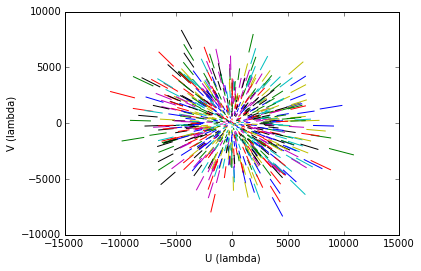

In [4]:
figure()
all_rlam = []
uvw = []
for ia1, a1 in enumerate(telnames):
    for ia2, a2 in enumerate(telnames[ia1+1:]):
        #u = [val[a1]['U (m)'] - val[a2]['U (m)'] for val in values]
        #v = [val[a1]['V (m)'] - val[a2]['V (m)'] for val in values]
        #w = [val[a1]['W (m)'] - val[a2]['W (m)'] for val in values]
        u = p[a1]['U (m)'] - p[a2]['U (m)']
        v = p[a1]['V (m)'] - p[a2]['V (m)']
        w = p[a1]['W (m)'] - p[a2]['W (m)']
        uvw.append((u,v,w))
        #print a1, a2, u, v, w
        ulam1, vlam1, wlam1 = u/lam1, v/lam1, w/lam1
        ulam2, vlam2, wlam2 = u/lam2, v/lam2, w/lam2
        r = np.sqrt(u*u + v*v)
        rlam1 = r/lam1
        rlam2 = r/lam2
        all_rlam.append((rlam1 - rlam2))
        plot([ulam1, ulam2], [vlam1, vlam2])
        plot([-ulam1, -ulam2], [-vlam1, -vlam2])

        
xlabel('U (lambda)')
ylabel('V (lambda)')
uvw = np.array(uvw)
uvwlam1 = uvw/lam1
uvwlam2 = uvw/lam2

In [5]:
assert(lam2 < lam1)

urange = uvwlam2[:, 0].max() - uvwlam2[:, 0].min()
vrange = uvwlam2[:, 1].max() - uvwlam2[:, 1].min()
lres = np.degrees(1.0/urange)*3600.
mres = np.degrees(1.0/vrange)*3600.
ucell = urange/float(Npix)*1.5
vcell = vrange/float(Npix)*1.5
size = np.degrees(1./ucell)
msize = np.degrees(1./vcell)
cellsize = min(ucell, vcell)

print 'UV range={:0.1f}x{:0.1f} lambda = {:0.1f}x{:0.1f} arcsec FoV: {:0.2f}x{:0.2f} deg'.format(urange, vrange, lres, mres,cellsize, msize)

UV range=19705.5x14493.3 lambda = 10.5x14.2 arcsec FoV: 84.92x0.67 deg


In [34]:
def baselines(telnames):
    nant = len(telnames)
    for i in xrange(nant):
        for j in xrange(i+1, nant):
            yield (telnames[i], telnames[j])
            
def runidxs(x):
    ''' Return the indexs of the start an end of a run of numbers that might be equal'''
    istart = 0
    for i in xrange(1, len(x)):
        if x[i] != x[istart]:
            yield (istart, i-1)
            istart = i
            
    yield (istart, i)

class BlFdmt(object):
    def __init__(self, a1, a2, uvpix, chanrange, freqrange, df, nd, nt):
        self.a1 = a1
        self.a2 = a2
        self.uvpix = uvpix # pixel coordinate in the uvplane
        assert chanrange[1] >= chanrange[0]
        self.chanrange = chanrange # 2 tupple of channel index (first, last)
        
        assert freqrange[1] >= freqrange[0]
        self.freqrange = freqrange #2 tuple of frequencies (frist, last)
        self.df = df
        self.nd = nd
        self.nt = nt
        self._fdmt = None
        
    @property
    def nchans(self):
        nc = (self.chanrange[1] - self.chanrange[0]) + 1
        return nc
    
    @property
    def fmin(self):
        return self.freqrange[0]
    
    @property
    def fdmt(self):
        '''Lazy initialise FDMT'''
        if self._fdmt is None:
            self._fdmt = fdmt.Fdmt(self.fmin, self.df, self.nchans, self.nd, self.nt)
            
        return self._fdmt
    
    def __str__(self):
        return '{}-{} uv={} chan={} freq={}'.format(self.a1, self.a2, self.uvpix, self.chanrange, self.freqrange)
        
def make_fdmts(p, telnames, freqs, uvcell, Npix, df, nd, nt):
    ucell, vcell = uvcell
    fdmts = []
    lambdas = constants.c / (freqs*1e9)
    for (a1, a2) in baselines(telnames):
         # UVW im meters
        u_m = p[a1]['U (m)'] - p[a2]['U (m)']
        v_m = p[a1]['V (m)'] - p[a2]['V (m)']
        w_m = p[a1]['W (m)'] - p[a2]['W (m)']
        
        # uvw in wavelengths - these are vectors becuase lambdas is a vector
        ulam = u_m/lambdas
        vlam = v_m/lambdas
        wlam = u_m/lambdas

        upix = np.round(ulam/ucell + Npix/2).astype(int) 
        vpix = np.round(vlam/vcell + Npix/2).astype(int)       

        assert np.all(upix >= 0), "invalid upix{}".format(upix)
        assert np.all(upix < Npix)
        assert np.all(vpix >=0)
        assert np.all(vpix < Npix), 'invalid vpix ibl={}{}{}'.format(a1,a2, vpix)

        # we'll walk through all the channels and work out what the start and stop channel for a given
        # UV cell is. Assume channels monitonically increasing
        uvpos = list(zip(upix, vpix))
        for istart, iend in runidxs(uvpos):
            uv = uvpos[istart]
            assert uvpos[istart] == uvpos[iend], 'Invalid run range uvpos[{}]={} uvpos[{}]={}'.format(istart, uvpos[istart], iend, uvpos[iend])
            b = BlFdmt(a1, a2, uv, (istart, iend), (freqs[istart], freqs[iend]), df, nd, nt)
            fdmts.append(b)

    return fdmts

def antno(antname):
    return int(antname[2:])

def write_fdmts(fdmts, fout):
    ''' WRite FDMT metadata to a file'''
    fdmts = sorted(fdmts, key=lambda f:f.uvpix)
    d = np.array([(antno(f.a1), antno(f.a2), f.uvpix[0], f.uvpix[1], f.chanrange[0], f.chanrange[1]) for f in fdmts], dtype=np.uint32)
    d.tofile(fout)
    np.savetxt?
    np.savetxt( fout+'.txt', d, fmt='%d',  header='ant1, ant2, u(pix), v(pix), chan1, chan2')

In [35]:
reload(fdmt)
fdmts = make_fdmts(p, telnames, freqs, (ucell, vcell), Npix, chanbw, Nd, Nt)
print 'GOT', len(fdmts), 'FDMTS'
write_fdmts(fdmts, 'fdmts.dat')

GOT 4367 FDMTS


In [8]:
for i in xrange(20):
    print fdmts[i]

AK01-AK02 uv=(129, 127) chan=(0, 287) freq=(1.1760000000000002, 1.463)
AK01-AK03 uv=(129, 128) chan=(0, 278) freq=(1.1760000000000002, 1.4540000000000002)
AK01-AK03 uv=(130, 128) chan=(279, 287) freq=(1.455, 1.463)
AK01-AK04 uv=(128, 129) chan=(0, 171) freq=(1.1760000000000002, 1.3470000000000002)
AK01-AK04 uv=(128, 130) chan=(172, 287) freq=(1.348, 1.463)
AK01-AK05 uv=(126, 130) chan=(0, 78) freq=(1.1760000000000002, 1.2540000000000002)
AK01-AK05 uv=(125, 130) chan=(79, 287) freq=(1.2550000000000001, 1.463)
AK01-AK06 uv=(133, 131) chan=(0, 153) freq=(1.1760000000000002, 1.3290000000000002)
AK01-AK06 uv=(134, 131) chan=(154, 287) freq=(1.33, 1.463)
AK01-AK07 uv=(136, 122) chan=(0, 52) freq=(1.1760000000000002, 1.2280000000000002)
AK01-AK07 uv=(136, 121) chan=(53, 130) freq=(1.229, 1.306)
AK01-AK07 uv=(137, 121) chan=(131, 242) freq=(1.3070000000000002, 1.4180000000000001)
AK01-AK07 uv=(137, 120) chan=(243, 283) freq=(1.419, 1.459)
AK01-AK07 uv=(138, 120) chan=(284, 287) freq=(1.4600000

In [9]:
def getfdmts(fdmts):
    for i in xrange(len(fdmts)):
        f = fdmts[i].fdmt
        

In [10]:
fdmts = make_fdmts(p, telnames, freqs, (ucell, vcell), Npix, chanbw, Nd, Nt)

%prun getfdmts(fdmts)

In [11]:
reload(fdmt)
fmin = 1.2
df = 1
nchans = 288
nd = 1024
nt = 256
fdmt.Fdmt(fmin, df, nchans, nd, nt)
%prun fdmt.Fdmt(fmin, df, nchans, nd, nt)

In [12]:
%timeit fdmt.Fdmt(fmin, df, nchans, nd, nt)

100 loops, best of 3: 15.3 ms per loop


In [13]:
#import cPickle as pickle
#with open('fdmts.pickle', 'w') as fout:
#    pickle.dump(fdmts, fout) # 1.5 GB - WTF?

In [37]:
total_state_size = 0
total_iterations = 0
total_elements_copied = 0
niter_on_chip = 3
nchan_per_run =16

lown_state_sizes = []
state_sizes = []
size_inflations = []
niters = []
n_in = 0
n_out = 0
for f in fdmts:
    sizes = [s.prod() for s in f.fdmt.hist_state_shape]
    n_in += sizes[0]
    n_out += sizes[-1]
    size_inflations.extend([sizes[i] - sizes[i-1] for i in xrange(1, len(sizes))])
    state_sizes.extend(sizes)
    niters.append(f.fdmt.niter)
    max_state_size = max(sizes)
    nelements_copied = sum(sizes)
    lown_state_sizes.extend([nchan_per_run*s[1]*s[2] for s in f.fdmt.hist_state_shape if s[0] >= nchan_per_run])

    total_elements_copied += nelements_copied
    total_state_size += max_state_size
    total_iterations += f.fdmt.niter
    
    nruns = (f.fdmt.niter + 1) // niter_on_chip
    #for irun in xrange(nruns):
    #    iterstart = irun*niter_on_chip
    ##    iterend = min(iterstart+niter_on_chip, f.fdmt.niter)
    #    for itidx, it in xrange(iterstart, iterend):
    #        nchanin = 2**(niter_on_chip - itidx)
    #        shapein = sizes[itidx][0:nchanin,:,:]

    
membw = total_elements_copied * nbytes /Tint/ nt / 1e9 * 2 # 2 for read + write
minimum_membw = (n_in + n_out)*nbytes/Tint/nt/1e9

print 'Got {} fdmts. {} iterations. nelemnts copied={:e} All iterations requires {} GBytes/sec. In/Out only (minium ){} GBytes/sec'.format(len(fdmts), total_iterations, total_elements_copied, membw, minimum_membw)
print "FFT read is", Nb*Nd/Tint*len(fdmts)/1e9, 'GBytes/sec'
Ndsp48 = 9000
print 'minimum', n_in*nbytes/Tint/nt/1e9, n_out*nbytes/Tint/nt/1e9, 'Gbytes/sec'

Got 4367 fdmts. 20718 iterations. nelemnts copied=2.008744e+10 All iterations requires 313.866197406 GBytes/sec. In/Out only (minium )57.8729730078 GBytes/sec
FFT read is 17.887232 GBytes/sec
minimum 13.154875 44.7180980078125 Gbytes/sec


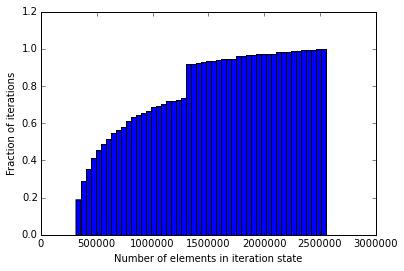

In [15]:
hist(state_sizes, bins=50, cumulative=True, normed=True)
xlabel('Number of elements in iteration state')
ylabel('Fraction of iterations')

(array([0.02270642, 0.04587156, 0.08830275, 0.16857798, 0.32316514,
        0.68830275, 0.93348624, 0.99220183, 1.        ]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5]),
 <a list of 9 Patch objects>)

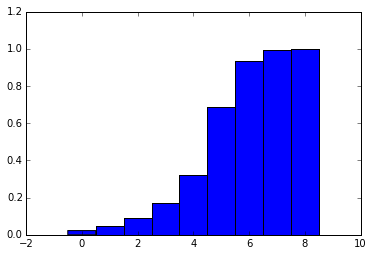

In [16]:
hist(niters, cumulative=True, normed=True, bins=np.arange(10)-0.5)

In [17]:
for s in fdmts[0].fdmt.hist_state_shape:
    print type(s), s, s.shape


<type 'numpy.ndarray'> [288   6 262] (3,)
<type 'numpy.ndarray'> [144  11 267] (3,)
<type 'numpy.ndarray'> [ 72  21 277] (3,)
<type 'numpy.ndarray'> [ 36  40 296] (3,)
<type 'numpy.ndarray'> [ 18  78 334] (3,)
<type 'numpy.ndarray'> [  9 152 408] (3,)
<type 'numpy.ndarray'> [  5 291 547] (3,)
<type 'numpy.ndarray'> [  3 540 796] (3,)
<type 'numpy.ndarray'> [   2  940 1196] (3,)
<type 'numpy.ndarray'> [   1 1024 1280] (3,)


(array([0.03444803, 0.12771958, 0.29572925, 0.46112006, 0.61361805,
        0.74315068, 0.85394843, 0.96897663, 0.99758259, 1.        ]),
 array([ 25152.,  66312., 107472., 148632., 189792., 230952., 272112.,
        313272., 354432., 395592., 436752.]),
 <a list of 10 Patch objects>)

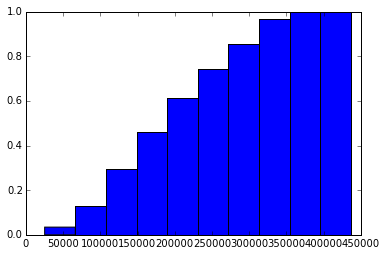

In [18]:
hist(lown_state_sizes, bins=10, normed=True,cumulative=True)

In [19]:
fdmts[2000].fdmt.hist_state_shape

[array([ 26,  42, 298]),
 array([ 13,  82, 338]),
 array([  7, 163, 419]),
 array([  4, 322, 578]),
 array([  2, 638, 894]),
 array([   1, 1024, 1280])]

(array([ 319.,  391.,  322.,  605., 3460., 9709., 3449.,  867.,  926.,
         670.]),
 array([-1246600. ,  -988433.1,  -730266.2,  -472099.3,  -213932.4,
           44234.5,   302401.4,   560568.3,   818735.2,  1076902.1,
         1335069. ]),
 <a list of 10 Patch objects>)

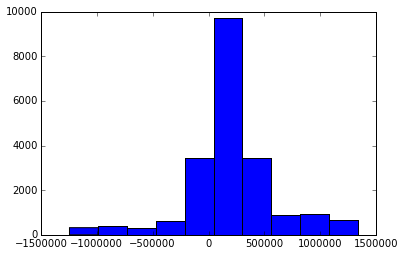

In [20]:
hist(size_inflations)

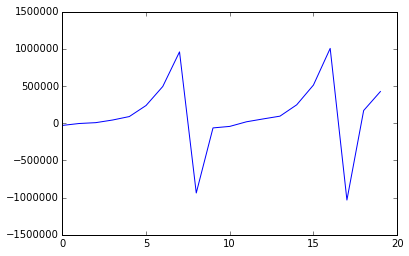

In [21]:
plot(size_inflations[0:20])


In [22]:
fdmts[0].fdmt.hist_state_shape

[array([288,   6, 262]),
 array([144,  11, 267]),
 array([ 72,  21, 277]),
 array([ 36,  40, 296]),
 array([ 18,  78, 334]),
 array([  9, 152, 408]),
 array([  5, 291, 547]),
 array([  3, 540, 796]),
 array([   2,  940, 1196]),
 array([   1, 1024, 1280])]

In [23]:
class CachingFdmtPlan(object):
    def __init__(self, _fdmt, cachesz):
        assert cachesz >= 0
        self.cachesz = cachesz
        self._fdmt = _fdmt
        ss = _fdmt.hist_state_shape

        # to start with, try to do all iterations in cache
        ss = np.array(ss)
        runs = []
        start_iter = 0
        max_niter = ss.shape[0]
        while start_iter < max_niter - 1:
            startnchan, niter = self.get_max_nchan(ss[start_iter:, :])
            end_iter = start_iter + niter
            runs.append((start_iter, end_iter, startnchan))
            start_iter += niter 
            
        self.runs = runs
        

    def get_max_nchan(self, ss):
        '''
        Calculates the number of channels and integrations that can be done at once in an FDMT
        constrained by the cache size.
        
        :ss: list of state shapes.
        
        :returns: (startnchan, niter) where startnchan is the number of channels from the first iteration that will be read in 
        niter is the number of iterations that can be performed
        '''
        ss = np.array(ss)
        startnchan = ss[0,0] # assume we can do all channels at once
        niter = 1
        ssize = ss.prod(axis=1)
        maxiter = ss.shape[0]
        #print 'cachesz', self.cachesz, ssize, ssize <= self.cachesz
        #print ss
        
        best_niter = 0
        best_nchan = 0
        while startnchan > 1:
            # number of iterations is the number of consequivie state sizes that is less than the cache size
            # Otherwise it's 1.
            fits = True          
            in_nchan = startnchan
            for istate in xrange(maxiter-1):
                ostate = istate + 1 # output state
                
                # if we're trying the full number of input channels, then assume we get the full number of output channels
                if in_nchan == ss[istate, 0]:
                    out_nchan = ss[ostate, 0]
                else:
                    out_nchan = in_nchan/2 # else the output nchan is the input nchan
                
                in_statesize = in_nchan*ss[istate, 1]*ss[istate, 2]
                out_statesize = out_nchan*ss[ostate, 1]*ss[ostate, 2]
                fits = in_statesize <= self.cachesz and out_statesize <= self.cachesz
                
                #print 'startnchan', startnchan, 'istate=',istate, ostate, in_nchan, out_nchan, \
                #    ss[istate], ss[ostate], in_statesize, out_statesize, \
                #    in_statesize < self.cachesz, out_statesize < self.cachesz, 'fits=', fits
               
                if not fits:
                    #print 'Does not fit in cache'
                    break
                    
                in_nchan = out_nchan
                if out_nchan == 1:
                    break # can't do any more
                    
            if fits:
                niter = istate + 1
            else:
                niter = istate
            
            #print 'Could fit {} iterations with {} startchan'.format(niter, startnchan)
            
            if niter > best_niter:
                best_niter = niter
                best_nchan = startnchan

            startnchan = int(2**floor(np.log2(startnchan) - 1))# halve startnchan
            #print 'Trying with new startnchan', startnchan
                
        if best_niter == 0:
            best_niter = 1
            best_nchan = ss[0,0]

        #print 'Returning', (best_nchan, best_niter)

        return (best_nchan, best_niter)
    
    @property
    def memory_transfers(self):
        inmem = 0
        outmem = 0
        for ir, (start_iter, end_iter, nchan) in enumerate(self.runs):
            inshape = self._fdmt.hist_state_shape[start_iter]
            outshape = self._fdmt.hist_state_shape[end_iter]
            inmem += inshape.prod()
            outmem += outshape.prod()
            
        naieve_in = sum([ss.prod() for ss in self._fdmt.hist_state_shape[0:-1]])
        naieve_out = sum([ss.prod() for ss in self._fdmt.hist_state_shape[1:]])
        return (inmem, outmem, naieve_in, naieve_out)

    
    def __str__(self):
        s = 'CachingFdmtPlan \n'
        ss = self._fdmt.hist_state_shape
        tcache_in = 0
        tcache_out = 0
        tnaieve_in = 0
        tnaieve_out = 0
        for ir, (start_iter, end_iter, nchan) in enumerate(self.runs):

            inshape = ss[start_iter]
            outshape = ss[end_iter]
            tcache_in += inshape.prod()
            tcache_out += outshape.prod()
            naieve_in = sum([ss[i].prod() for i in xrange(start_iter, end_iter)])
            naieve_out = sum([ss[i].prod() for i in xrange(start_iter+1, end_iter+1)])
            tnaieve_in += naieve_in
            tnaieve_out += naieve_out
            s += 'run {} iter{}-{} in_nchan={} inshape={} outshape={} in={} out={} naive in={} out={}\n'.format(ir, start_iter, end_iter,
                                                                                nchan, inshape, outshape,
                                                                               inshape.prod(), outshape.prod(),
                                                                               naieve_in, naieve_out)
            
        inmem, outmem, naieve_in, naieve_out = self.memory_transfers
        try:
            saving = float(tnaieve_in + tnaieve_out)/float(tcache_in+tcache_out)
        except ZeroDivisionError:
            saving = np.nan

        s += 'Totals cache in= {} out={} naieve in={} out={}  saving={}x'.format(tcache_in, tcache_out, tnaieve_in, tnaieve_out, \
                                                                         saving)
        #s += '\nMT Bits'+str(self.memory_transfers)
        return s
                

cfdmt = CachingFdmtPlan(fdmts[0].fdmt, 32768)
print cfdmt.runs, cfdmt._fdmt.niter
print cfdmt
print([ss.prod() for ss in cfdmt._fdmt.hist_state_shape])
    

[(0, 4, 16), (4, 5, 18), (5, 6, 9), (6, 7, 5), (7, 8, 3), (8, 9, 2)] 9
CachingFdmtPlan 
run 0 iter0-4 in_nchan=16 inshape=[288   6 262] outshape=[ 18  78 334] in=452736 out=468936 naive in=1720728 out=1736928
run 1 iter4-5 in_nchan=18 inshape=[ 18  78 334] outshape=[  9 152 408] in=468936 out=558144 naive in=468936 out=558144
run 2 iter5-6 in_nchan=9 inshape=[  9 152 408] outshape=[  5 291 547] in=558144 out=795885 naive in=558144 out=795885
run 3 iter6-7 in_nchan=5 inshape=[  5 291 547] outshape=[  3 540 796] in=795885 out=1289520 naive in=795885 out=1289520
run 4 iter7-8 in_nchan=3 inshape=[  3 540 796] outshape=[   2  940 1196] in=1289520 out=2248480 naive in=1289520 out=2248480
run 5 iter8-9 in_nchan=2 inshape=[   2  940 1196] outshape=[   1 1024 1280] in=2248480 out=1310720 naive in=2248480 out=1310720
Totals cache in= 5813701 out=6671685 naieve in=7081693 out=7939677  saving=1.2031161872x
[452736, 422928, 418824, 426240, 468936, 558144, 795885, 1289520, 2248480, 1310720]


In [24]:
cache_plans = [CachingFdmtPlan(f.fdmt, 32768*32) for f in fdmts]

In [25]:
cache_mem = np.array([cfdmt.memory_transfers for cfdmt in cache_plans]).astype(float)
print np.where(cache_mem[:, 0] == 0)
print cache_plans[33].runs

(array([  33,   79,  145,  183,  203,  215,  373,  380,  440,  463,  518,
        574,  711,  753,  822,  838,  991, 1000, 1180, 1221, 1317, 1353,
       1360, 1378, 1410, 1422, 1471, 1610, 1646, 1652, 1700, 1799, 1807,
       1841, 1846, 1854, 1911, 1955, 2019, 2031, 2071, 2090, 2367, 2443,
       2445, 2472, 2538, 2578, 2597, 2644, 2694, 2754, 2797, 2806, 2827,
       2835, 2836, 2862, 2879, 2936, 2965, 2970, 2998, 3031, 3034, 3077,
       3098, 3116, 3130, 3160, 3248, 3264, 3297, 3378, 3382, 3386, 3401,
       3428, 3528, 3548, 3596, 3650, 3683, 3695, 3708, 3738, 3756, 3794,
       3807, 3865, 3926, 3950, 3966, 4009, 4024, 4135, 4136, 4232, 4233]),)
[]


(array([463.,   0.,   0.,   0.,   0., 152., 270.,   0.,   0., 424.,   0.,
        484., 576., 320.,   0., 190., 324., 120.,   2.,  21.,  19.,  46.,
        176.,  99.,   4.,   6.,   3.,   7.,   2.,   4.,  74., 283.,  80.,
          0.,   0.,   0.,   0.,   0.,  19.,  22.,  62.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   9.,   7.]),
 array([1.        , 1.0258377 , 1.05167539, 1.07751309, 1.10335079,
        1.12918849, 1.15502618, 1.18086388, 1.20670158, 1.23253927,
        1.25837697, 1.28421467, 1.31005237, 1.33589006, 1.36172776,
        1.38756546, 1.41340315, 1.43924085, 1.46507855, 1.49091625,
        1.51675394, 1.54259164, 1.56842934, 1.59426703, 1.62010473,
        1.64594243, 1.67178013, 1.69761782, 1.72345552, 1.74929322,
        1.77513091, 1.80096861, 1.82680631, 1.85264401, 1.8784817 ,
        1.9043194 , 1.9301571 , 1.95599479, 1.98183249, 2.00767019,
        2.03350789, 2.05934558, 2.08518328, 2.11102098, 2.13685867,
        2.16269637, 2.18853407, 2.21437176, 2.

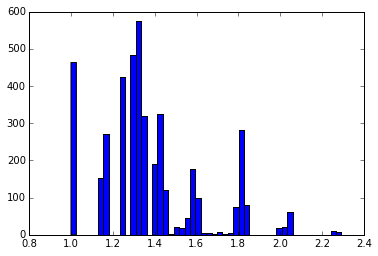

In [26]:
naive = cache_mem[:, 2:].sum(axis=1)
caching = cache_mem[:, :2].sum(axis=1)
mask = caching != 0
saving = naive[mask]/caching[mask]
hist(saving, bins=50)


In [27]:
total_membw = cache_mem.sum(axis=0)
cache_membw = total_membw[:2].sum()
naive_membw = total_membw[2:].sum()

print 'Total mem bw', total_membw, 'entries per block'
print 'Required caching membw for 1x real time', cache_membw*nbytes/Tint/nt/1e9, 'GBytes/sec'
print 'Required naieve membw for 1x real time', naive_membw*nbytes/Tint/nt/1e9, 'GBYtes/sec'
print 'Total improvement', naive_membw/cache_membw

Total mem bw [1.01448174e+10 1.41849100e+10 1.43635201e+10 1.84036126e+10] entries per block
Required caching membw for 1x real time 190.0759955390625 GBytes/sec
Required naieve membw for 1x real time 255.9932243984375 GBYtes/sec
Total improvement 1.3467940739830473


In [28]:
len(fdmts)*Nd*4*256/1e9

4.579131392

In [29]:
print cache_plans[0]

CachingFdmtPlan 
run 0 iter0-7 in_nchan=128 inshape=[288   6 262] outshape=[  3 540 796] in=452736 out=1289520 naive in=3543693 out=4380477
run 1 iter7-8 in_nchan=3 inshape=[  3 540 796] outshape=[   2  940 1196] in=1289520 out=2248480 naive in=1289520 out=2248480
run 2 iter8-9 in_nchan=2 inshape=[   2  940 1196] outshape=[   1 1024 1280] in=2248480 out=1310720 naive in=2248480 out=1310720
Totals cache in= 3990736 out=4848720 naieve in=7081693 out=7939677  saving=1.69935457567x


In [30]:
[ss.prod() for ss in cache_plans[0]._fdmt.hist_state_shape]
2248480

2248480

In [31]:
cachesz = []
cachemb = []
for cache_nentries in 2**np.arange(8, 21):
    cache_plans = [CachingFdmtPlan(f.fdmt, cache_nentries) for f in fdmts]
    cache_mem = np.array([cfdmt.memory_transfers for cfdmt in cache_plans]).astype(float)
    total_membw = cache_mem.sum(axis=0)
    cache_membw = total_membw[:2].sum()*nbytes/Tint/nt/1e9
    cachesz.append(cache_nentries*nbytes)
    cachemb.append(cache_membw)

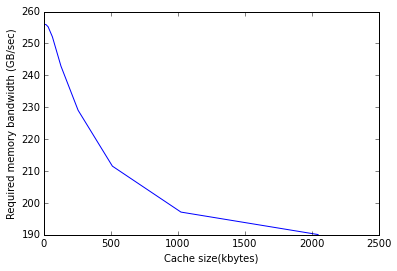

In [32]:
plot(np.array(cachesz)/1024, cachemb)
xlabel('Cache size(kbytes)')
ylabel('Required memory bandwidth (GB/sec)')